## Load Routines for Printing Matrices

In [1]:
using Dates           

include("printmat.jl")
include("printTable.jl")

println4Ps (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Exchange Rate Quotations: Cross-Rates

In [3]:
CHF_USD = 0.9970                       #how many CHF to pay for 1 USD
USD_AUD = 0.8139

CHF_AUD = CHF_USD*USD_AUD

printlnPs("CHF per AUD: ",CHF_AUD)

CHF per AUD:      0.811


# Currency Returns

The strategy is: in $t=0$, you borrow on the domestic money market (at the safe rate $R_f$), buy foreign currency (at the price $S_0$) and lend on foreign money market (at the safe rate $R_f^*$). Finally, in $t=1$ sell the foreign currency (at the price $S_1$). 

Since the strategy is financed by borrowing, we express the excess return as 

$
R^e = (1+R_f^*)S₁/S₀ - 1 - R_f
$

Notice that Rf and Rfstar are the safe rates over the investment period (for instance, one-month period). Conversion from annualized interest rates to these monthly rates is discussed under UIP (below).

In [4]:
S₀ = 1.2            #current spot FX rate, t=0
S₁ = 1.25           #spot FX rate in t=1
Rfstar = 0.06      #safe rate (foreign) between period 0 and 1
Rf     = 0.04      #safe domestic rate

Re = (1+Rfstar)*S₁/S₀ - 1 - Rf

xy = [S₀,Rf,Rfstar,S₁,Re]
printTable(xy,[" "],["S₀";"Rf";"Rfstar";"S₁";"Currency excess return "])

                                 
S₀                          1.200
Rf                          0.040
Rfstar                      0.060
S₁                          1.250
Currency excess return      0.064



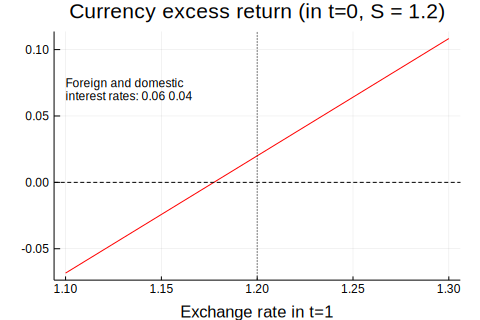

In [5]:
S₁ = 1.1:0.01:1.3           #vector, different possible exchange rates in t=1

Re = (1+Rfstar)*S₁/S₀ .- (1 + Rf)

p1 = plot(S₁,Re,legend=nothing,color=:red)
plot!([S₀],linetype=:vline,linecolor=:black,line=(:dot,1))
plot!([0],linetype=:hline,linecolor=:black,line=(:dash,1))
title!("Currency excess return (in t=0, S = $S₀)")
xlabel!("Exchange rate in t=1")
annotate!(1.1,0.07,text("Foreign and domestic \ninterest rates: $Rfstar $Rf",8,:left))

# Uncovered Interest Rate Parity (UIP)


UIP assumes that the expected future exchange rate (E$_0S_m$) is related to the current (as of $t=0$) exchange rate and interest rates, in such a way that the expected excess return on a a foreign investment (on the foreign money market) is zero.

Interest rates are typically annualized (denoted $y$ and $y^*$ below). This means that the safe rate over an investment period of $m$ years (eg. $m=1/12$ for a month) is $(1+y)^m$.

In [6]:
S₀     = 1.2                       #current spot FX rate
y     = 0.04                      #annualized interest rates
ystar = 0.06
m     = 1/2                       #investment period  
ESm   = S₀ * (1+y)^m/(1+ystar)^m  #implies E(excess return) = 0

printlnPs("Expected future exchange rate $m years ahead according to UIP: ",ESm)

Expected future exchange rate 0.5 years ahead according to UIP:      1.189
